In [1]:
# !conda install -q -U bitsandbytes
# !conda install -q xformers
# !conda install -q -U git+https://github.com/huggingface/transformers.git
# !conda install -q -U git+https://github.com/huggingface/peft.git
# !conda install -q -U git+https://github.com/huggingface/accelerate.git
# !conda install -q datasets
# !conda install -q einops
# !conda install -q wandb
# !conda install -q scipy

In [2]:
from huggingface_hub import login
login()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [4]:
import pandas as pd
from datasets import load_dataset

SQL_SPECIAL_TOKENS = {
    'schema': '<|schema|>',
    'query': '<|query|>',
    'sql': '<|sql|>',
    'endoftext': '<|endoftext|>',
}

def generate_prompt(examples, spider_schemas, use_fields=False):
    """
    Generates the prompt for the given example as follows:
    <|schema|> DATABASE STRUCTURE <|query|> NATURAL LANGUAGE QUESTION <|sql|> SQL QUERY <|endoftext|>

    examples: The example to generate the prompt for.
    spider_schemas: The spider schemas object.
    use_fields: Whether to use the database fields in the prompt.
    """
    prompt = ''

    if use_fields:
      fields = SQL_SPECIAL_TOKENS['schema'] + spider_schemas.get_db_schema(examples['db_id']) + SQL_SPECIAL_TOKENS['endoftext']
      fields.strip()
      prompt += fields

    question = SQL_SPECIAL_TOKENS['query'] + examples['question'] + SQL_SPECIAL_TOKENS['endoftext']
    question.strip()
    prompt += question

    query = SQL_SPECIAL_TOKENS['sql'] + examples['query']
    query.strip()

    if not query.endswith(';'):
        query = query + ';'
    query = query + SQL_SPECIAL_TOKENS['endoftext']

    prompt += query

    return prompt.lower()

def preprocess_function(examples, spider_schema, use_fields=False):
    prompts = generate_prompt(examples, spider_schema, use_fields)
    return {'input_text': prompts}

class SpiderSchema:
    """
    Class to handle the spider dataset schemas.
    """
    def __init__(self, table_json: str):
        self.schema, self.primary, self.foreign = self.get_spider_schemas(table_json)

    def find_db_fields(self, db_name: str):
        """
        Returns the fields of the database with the given name as a string.
        """
        df = self.schema[self.schema['Database name'] == db_name]
        df = df.groupby(' Table Name')
        output = ""
        for name, group in df:
            output += "Table " +name+ ', columns = ['
            for index, row in group.iterrows():
                output += row[" Field Name"]+','
            output = output[:-1]
            output += "]\n"
        return output

    def find_db_primary_keys(self, db_name: str):
        """
        Returns the primary keys of the database with the given name as a string.
        """
        df = self.primary[self.primary['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['Table Name'] + '.' + row['Primary Key'] +','
        if len(output)>1:
            output = output[:-1]
        output += "]\n"
        return output

    def find_db_foreign_keys(self, db_name: str):
        """
        Returns the foreign keys of the database with the given name as a string.
        """
        df = self.foreign[self.foreign['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['First Table Name'] + '.' + row['First Table Foreign Key'] + " = " + row['Second Table Name'] + '.' + row['Second Table Foreign Key'] + ','
        output= output[:-1] + "]"
        return output

    def get_db_schema(self, db_name: str) -> str:
        """
        Returns the schema of the database with the given name as a string.
        """
        fields = self.find_db_fields(db_name)
        fields += "Foreign_keys = " + self.find_db_primary_keys(db_name) + '\n'
        fields += "Primary_keys = " + self.find_db_foreign_keys(db_name)
        return fields

    @staticmethod
    def get_spider_schemas(table_json: str):
        """
        Returns the schemas of the spider dataset as pandas dataframes, with the following columns:
        - spider_schema: Database name, Table Name, Field Name, Type
        - spider_primary: Database name, Table Name, Primary Key
        - spider_foreign: Database name, First Table Name, Second Table Name, First Table Foreign Key, Second Table Foreign Key

        :param table_json: path to the table.json file of the spider dataset
        :return: spider_schema, spider_primary, spider_foreign
        """
        schema_df = pd.read_json(table_json)
        schema_df = schema_df.drop(['column_names','table_names'], axis=1)
        schema = []
        f_keys = []
        p_keys = []
        for index, row in schema_df.iterrows():
            tables = row['table_names_original']
            col_names = row['column_names_original']
            col_types = row['column_types']
            foreign_keys = row['foreign_keys']
            primary_keys = row['primary_keys']
            for col, col_type in zip(col_names, col_types):
                index, col_name = col
                if index == -1:
                    for table in tables:
                        schema.append([row['db_id'], table, '*', 'text'])
                else:
                    schema.append([row['db_id'], tables[index], col_name, col_type])
            for primary_key in primary_keys:
                index, column = col_names[primary_key]
                p_keys.append([row['db_id'], tables[index], column])
            for foreign_key in foreign_keys:
                first, second = foreign_key
                first_index, first_column = col_names[first]
                second_index, second_column = col_names[second]
                f_keys.append([row['db_id'], tables[first_index], tables[second_index], first_column, second_column])
        spider_schema = pd.DataFrame(schema, columns=['Database name', ' Table Name', ' Field Name', ' Type'])
        spider_primary = pd.DataFrame(p_keys, columns=['Database name', 'Table Name', 'Primary Key'])
        spider_foreign = pd.DataFrame(f_keys,
                            columns=['Database name', 'First Table Name', 'Second Table Name', 'First Table Foreign Key',
                                    'Second Table Foreign Key'])
        return spider_schema, spider_primary, spider_foreign


def get_dataset(table_json: str, dataset_name: str='spider', use_fields: bool = False):

    dataset = load_dataset(dataset_name)
    spider_schema = SpiderSchema(table_json)
    dataset = dataset.map(
        lambda examples: preprocess_function(examples, spider_schema, use_fields),
        remove_columns=dataset["train"].column_names,
    )
    return dataset

In [5]:
model_id = "meta-llama/Llama-2-7b-hf"
dataset_id = 'spider'
spider_schema = './tables.json'

In [6]:
dataset = get_dataset(spider_schema, dataset_id, use_fields=True)

Found cached dataset spider (/home/CIN/gme/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/CIN/gme/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa/cache-9738fd702dfd9d0a.arrow
Loading cached processed dataset at /home/CIN/gme/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa/cache-a6b53e57db5cd20a.arrow


In [7]:
from torch.utils.data import Dataset, DataLoader
import torch

class InferenceDataset(Dataset):
    """
    Dataset for inference.

    Arguments:
        dataset: The dataset to use.
        prefix: The prefix to use for the prompt.
    """

    def __init__(self, dataset, prefix = 'Convert text into SQL statements by providing a database schema and a query, and generate the corresponding SQL statement.'):
        self.dataset = dataset
        self.prefix = prefix

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.dataset[idx]

        return self.prefix + sample['input_text'].split('<|sql|>')[0] + '<|sql|>'

In [8]:
eval_batch_size = 1

inference_ds = InferenceDataset(dataset['validation'])
inference_dataloader = DataLoader(inference_ds, batch_size=eval_batch_size, shuffle=False)

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, StoppingCriteriaList, StoppingCriteria
from typing import Optional
from peft import get_peft_model, PeftModel, prepare_model_for_kbit_training

def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

def get_model(model_id: str, bnb_config: BitsAndBytesConfig):
    if bnb_config is None:
        model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, trust_remote_code=True)
    return model

def get_tokenizer(model_id: str):
    tokenizer = AutoTokenizer.from_pretrained(model_id, do_lower_case=True)
    return tokenizer

def add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS):
    """
    Add special tokens to the tokenizer
    """

    tokenizer.add_special_tokens(
        {
            "pad_token": tokenizer.eos_token,
            "sep_token": tokenizer.eos_token,
        }
    )

    additional_special_tokens = (
        []
        if "additional_special_tokens" not in tokenizer.special_tokens_map
        else tokenizer.special_tokens_map["additional_special_tokens"]
    )

    additional_special_tokens = list(set(additional_special_tokens + list(SQL_SPECIAL_TOKENS.values())))

    num_special_tokens = tokenizer.add_special_tokens({"additional_special_tokens": additional_special_tokens})

    return tokenizer, num_special_tokens

def add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS):
    """
    Adds the special tokens embeddings to the model.
    Embeddings are calculated as the mean of the sub-words embeddings.
    """

    # map new tokens
    new_tokens_ids = {}

    for value in SQL_SPECIAL_TOKENS.values():
      ids = tokenizer(value)['input_ids']
      if len(ids) > 1:
        new_tokens_ids[value] = ids

    # retrieve embedding weigths
    embeddings_key = ''
    for k in model.state_dict().keys():
        if 'embed_tokens.weight' in k:
            embeddings_key = k
            break
    embeddings_weights = model.state_dict()[embeddings_key].clone()

    # calculate new tokens embeddings weigths as mean of the sub-words embeddings
    new_tokens_emb_weights = {}

    for token in new_tokens_ids.keys():
      token_emb_list = []
      for ids in new_tokens_ids[token]:
        token_emb = embeddings_weights[ids].clone()
        token_emb_list.append(token_emb)
      token_emb_tensor = torch.stack(token_emb_list)
      # mean of the sub-words embeddings
      mean_emb = torch.mean(token_emb_tensor, dim=0)
      new_tokens_emb_weights[token] = mean_emb

    # add new tokens and special tokens to the tokenizer vocab
    tokenizer, num_special_tokens = add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS)

    # resize model embedding
    model.resize_token_embeddings(len(tokenizer))

    vocab_size = tokenizer.vocab_size

    new_embs = model.state_dict()[embeddings_key][
        vocab_size : vocab_size + num_special_tokens, :
    ].clone()

    # add new weights to the model.state_dict
    for token in new_tokens_emb_weights.keys():
      new_ids = tokenizer(token)['input_ids']
      model.state_dict()[embeddings_key][new_ids] = new_tokens_emb_weights[token]

    return new_embs

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def get_pretrained_model_and_tokenizer(model_id: str, bnb_config: Optional[BitsAndBytesConfig], lora_id: str, add_embeddings: bool = True):
    tokenizer = get_tokenizer(model_id)
    model = get_model(model_id, bnb_config)

    if add_embeddings:
        add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS)

    if lora_id:
        model.gradient_checkpointing_enable()
        model = prepare_model_for_kbit_training(model)
        model = PeftModel.from_pretrained(model, lora_id, torch_dtype=torch.bfloat16)

    return model, tokenizer

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_id = 'gabrielgme/llama2-7b-2-2ep-spider-with-schema'

model, tokenizer = get_pretrained_model_and_tokenizer(model_id, bnb_config, lora_id)#, lora_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

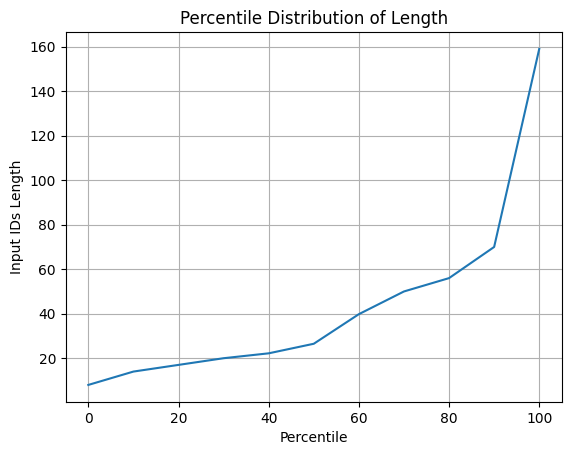

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_function(examples):
    return tokenizer(examples['input_text'].split('<|sql|>')[-1])

tokenized_ds = dataset['validation'].map(
    preprocess_function,
    remove_columns=dataset['validation'].column_names,
)

input_ids_lengths = []

for prompt in tokenized_ds:
  input_ids_lengths.append(len(prompt['input_ids']))


percentiles = np.percentile(input_ids_lengths, range(0, 101, 10))

plt.plot(range(0, 101, 10), percentiles)
plt.xlabel("Percentile")
plt.ylabel("Input IDs Length")
plt.title("Percentile Distribution of Length")
plt.grid(True)
plt.show()

In [15]:
import transformers
from tqdm import tqdm

STOP_WORDS = [';', ');', '\';', '";', '<|endoftext|>']

class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords_ids:list):
        self.keywords = keywords_ids

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if input_ids[0][-1] in self.keywords:
            return True
        return False

def get_stopping_criteria(tokenizer, stop_words=STOP_WORDS):
    stop_ids = [tokenizer.encode(w)[0] for w in stop_words]
    keyword_criteria = KeywordsStoppingCriteria(stop_ids)
    stopping_criteria = StoppingCriteriaList([keyword_criteria])
    return stopping_criteria

def get_pipeline(model, tokenizer):
    pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        device_map="auto",
    )
    return pipeline

def generate(model, tokenizer, inference_dataloader, max_length=512, max_new_tokens=20, limit_generation=None):
    stopping_criteria = get_stopping_criteria(tokenizer)
    results = []

    generation_config = model.generation_config
    generation_config.max_new_tokens = max_new_tokens
    generation_config.temperature = 0.2
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.eos_token_id = tokenizer.eos_token_id
    generation_config.max_length = max_length


    for batch in tqdm(inference_dataloader):
        encoding = tokenizer(batch, return_tensors="pt").to(model.device)
        with torch.inference_mode():
            outputs = model.generate(
                input_ids=encoding["input_ids"],
                attention_mask=encoding["attention_mask"],
                generation_config=generation_config,
                stopping_criteria=stopping_criteria,
                do_sample=False,
                use_cache=True,
            )
        for output in outputs:
            output = tokenizer.decode(output).split('<|sql|>')[-1]
            results.append(output)
        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results

def generate_pipeline(pipeline,
                      inference_dataloader,
                      eos_token_id,
                      pad_token_id,
                      limit_generation=None,
                      max_new_tokens=20,
                      ):
    results = []
    for batch in tqdm(inference_dataloader):
        out = pipeline(batch,
                       do_sample=False,
                       max_new_tokens=max_new_tokens,
                       temperature=0.2,
                       top_k=3,
                       top_p=0.9,
                       repetition_penalty=1.2,
                       num_return_sequences=1,
                       eos_token_id=eos_token_id,
                       pad_token_id=pad_token_id,)
        for res in out:
            prediction = res[0]['generated_text'].split('<|sql|>')[-1]
            results.append(prediction)

        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results


In [16]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True

In [17]:
%%time
pipeline = get_pipeline(model, tokenizer)
results = generate_pipeline(pipeline, inference_dataloader, tokenizer.eos_token_id, tokenizer.pad_token_id, max_new_tokens=68) # max new tokens is 160 because the 90th percentile of the input ids length is 160
save_path = './llama27b2ep.txt'
print('Saving inferences on ', save_path)
with open(save_path, 'w') as f:
    f.write("<separator>".join(results))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausa

Saving inferences on  ./llama27b2ep.txt
CPU times: user 55min 27s, sys: 971 ms, total: 55min 28s
Wall time: 55min 27s


: 

In [ ]:
# save_path = './falcon7binstruct.txt'

In [ ]:
# print('Saving inferences on ', save_path)
# with open(save_path, 'w') as f:
#     f.write("<separator>".join(results))

: 